In [90]:
import yfinance as yf
import numpy as np
import pandas as pd
import os
import json

DATA_PATH = "nvda_data.json"

if os.path.exists(DATA_PATH):
    with open(DATA_PATH) as f: 
        nvda_hist = pd.read_json(DATA_PATH)
else:
    nvda = yf.Ticker("NVDA")
    nvda_hist = nvda.history(period="max")
    
    nvda_hist.to_json(DATA_PATH)

In [91]:
nvda_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1999-01-22,0.401892,0.448540,0.356440,0.376774,271468800.0,0.0,0.0
1999-01-25,0.406676,0.421030,0.376774,0.416245,51048000.0,0.0,0.0
1999-01-26,0.421029,0.429403,0.377970,0.383951,34320000.0,0.0,0.0
1999-01-27,0.385147,0.394716,0.363616,0.382755,24436800.0,0.0,0.0
1999-01-28,0.382755,0.385147,0.379166,0.381559,22752000.0,0.0,0.0


<AxesSubplot:>

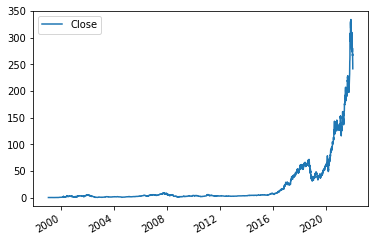

In [92]:
nvda_hist.plot.line(y="Close", use_index=True)

In [93]:
data = nvda_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})
data["Target"] = nvda_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [94]:
data.head(5)

,Actual_Close,Target
1999-01-22,0.376774,NaN
1999-01-25,0.416245,1.0
1999-01-26,0.383951,0.0
1999-01-27,0.382755,0.0
1999-01-28,0.381559,0.0


In [95]:
#making sure to prevent leakage by using todays data to predict tomorrows price

In [96]:
nvda_prev = nvda_hist.copy()
nvda_prev = nvda_prev.shift(1)

In [97]:
nvda_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1999-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-25,0.401892,0.448540,0.356440,0.376774,271468800.0,0.0,0.0
1999-01-26,0.406676,0.421030,0.376774,0.416245,51048000.0,0.0,0.0
1999-01-27,0.421029,0.429403,0.377970,0.383951,34320000.0,0.0,0.0
1999-01-28,0.385147,0.394716,0.363616,0.382755,24436800.0,0.0,0.0


In [98]:
#set the parameters for the model to use and trim the first row of data
#maybe use grid search to find more optimal parameters
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(nvda_prev[predictors]).iloc[1:]               

In [99]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
1999-01-25,0.416245,1.0,0.376774,271468800.0,0.401892,0.448540,0.356440
1999-01-26,0.383951,0.0,0.416245,51048000.0,0.406676,0.421030,0.376774
1999-01-27,0.382755,0.0,0.383951,34320000.0,0.421029,0.429403,0.377970
1999-01-28,0.381559,0.0,0.382755,24436800.0,0.385147,0.394716,0.363616
1999-01-29,0.363616,0.0,0.381559,22752000.0,0.382755,0.385147,0.379166


In [100]:
data.tail(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
2022-01-13,265.750000,0.0,279.989990,38341300.0,280.670013,285.950012,276.079987
2022-01-14,269.420013,1.0,265.750000,54017100.0,283.790009,284.799988,264.980011
2022-01-18,259.029999,0.0,269.420013,39522800.0,263.000000,271.970001,262.100006
2022-01-19,250.669998,0.0,259.029999,42427000.0,262.600006,266.380005,257.700012
2022-01-20,241.500000,0.0,250.669998,48831500.0,260.790009,265.429993,250.520004


In [101]:
#using RandomForest model
from sklearn.ensemble import RandomForestClassifier
#with 100 decision trees whose results are averaged, upwards of 500 might be better
#and to prevent overfitting of the data, samplesplit is set to 200
#random state allows for consistency between multiple runs on the same data
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
#cannot use cross validation i.e. can't use data from 2021 to predict 2020
train = data.iloc[:-100]
test = data.iloc[-100:]
#using the parameters from predictors, lets predict the target 
model.fit(train[predictors], train["Target"])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
from sklearn.metrics import precision_score
#Error of the predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)